## Data Cleaning and TV Probability Calculation

In this notebook we want to clean the data sets, create new columns to analyse tv spot interactions and calculate TV probabilities. 

In [1]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# calling functions from the manual created util file
from util import (
    df_first_look,
    file_read,
    sessions_final_df_cleaning,
    tv_spot_identifier_time_series_chart,
)
from datetime import datetime
from datetime import timedelta
from matplotlib.pyplot import figure

# adding options to visualise all rows and columns in the project
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

# ignoring warnings
warnings.filterwarnings("ignore")

# adding useful magic functions
%load_ext lab_black
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
# Reading all files into the data frames
(
    sessions_final_df,
    audience_df,
    tv_planning_df,
    tv_spots_df,
    tv_visits_match_df,
) = file_read()

## Data Cleaning and Feature Creation Plan

* Filter out dates are not relevant to visits from TV Planning Data Frame.
* Merge TV Planning and TV Spot Data Frames to calculate at when our spots started and ended during the show spot block.
* Calculating one minute duration visit aggregations at Sessions Data Frame.

### TV Planning Date Filtering

In the sessions data set we only focus on 15th of May 2020. Regarding this we need to filter out other days from TV Planning data set.

In [3]:
# getting only 15th of May 2020 data
tv_planning_df = tv_planning_df[
    (tv_planning_df["block_start_time"].dt.strftime("%Y-%m-%d") == "2020-05-15")
].copy()

In [4]:
# we only have 15th of May spots
tv_planning_df

,tvp_id,block_start_time,tv_show,block_size,block_position,spot_id
42,10001127236681063068_1553644644,2020-05-15 18:05:00,First Dates - Ein Tisch für zwei,420.0,345.0,4234.0
43,10001127236681063068_1553644645,2020-05-15 18:10:00,SOKO Kitzbühel,300.0,270.0,6232.0
44,10001127236681063068_1553644646,2020-05-15 19:35:00,Alles was zählt,480.0,60.0,8331.0
45,10001127236681063068_15536446461,2020-05-15 19:40:00,Comeback oder weg?,300.0,180.0,7224.0
46,10001127236681063068_1553644647,2020-05-15 20:15:00,Jack Reacher,60.0,15.0,6232.0


### TV Planning and TV Spots: Joining and Feature Calculations

* TV Planning Data Frame is our main data set to get the advertisement block hours.
* TV Spot Data Frame contains information about each advertisement. 
* We need to join these tables and calculate when our advertisements start and end during each show's advertisement block hours.

In [5]:
# we are joining tables on spot_id.
tv_show_spot_df = pd.merge(tv_planning_df, tv_spots_df, how="left", on="spot_id")

In [6]:
tv_show_spot_df.head()

,tvp_id,block_start_time,tv_show,block_size,block_position,spot_id,spot_name,duration
0,10001127236681063068_1553644644,2020-05-15 18:05:00,First Dates - Ein Tisch für zwei,420.0,345.0,4234.0,springsummer_branding,30 secs
1,10001127236681063068_1553644645,2020-05-15 18:10:00,SOKO Kitzbühel,300.0,270.0,6232.0,springsummer_outfitfashionA,15 secs
2,10001127236681063068_1553644646,2020-05-15 19:35:00,Alles was zählt,480.0,60.0,8331.0,springsummer_saleB,7 secs
3,10001127236681063068_15536446461,2020-05-15 19:40:00,Comeback oder weg?,300.0,180.0,7224.0,springsummer_saleA,7 secs
4,10001127236681063068_1553644647,2020-05-15 20:15:00,Jack Reacher,60.0,15.0,6232.0,springsummer_outfitfashionA,15 secs


In [7]:
# in duration column there is a string suffix ' secs'. We need to clean this part to have numeric values.
tv_show_spot_df["duration_numeric"] = pd.to_numeric(
    tv_show_spot_df["duration"].str.split(" ", expand=True)[0]
)

### Advertisement Start and End Time Calculations

* `block_start_time`: Advertisement starting time during the tv show
* `block_size`: Total advertisement time block in terms of seconds
* `block_position`: When our advertisement starts in terms of seconds in the block_size
* `duration`: How long our advertiesement is shown in terms of seconds

Here we need to calculate when our advertisement starts and ends in terms of normal time format

In [8]:
# calculating when our advertisement starts during the tv show advertiesement block
tv_show_spot_df["block_position_second"] = pd.to_timedelta(
    tv_show_spot_df["block_position"], unit="s"
)
tv_show_spot_df["ads_start_time"] = (
    tv_show_spot_df["block_start_time"] + tv_show_spot_df["block_position_second"]
)

In [9]:
# calculating when our advertisement ends during the tv show advertiesement block
tv_show_spot_df["duration_numeric_second"] = pd.to_timedelta(
    tv_show_spot_df["duration_numeric"], unit="s"
)
tv_show_spot_df["ads_end_time"] = (
    tv_show_spot_df["ads_start_time"] + tv_show_spot_df["duration_numeric_second"]
)

In [10]:
tv_show_spot_df.head()

,tvp_id,block_start_time,tv_show,block_size,block_position,spot_id,spot_name,duration,duration_numeric,block_position_second,ads_start_time,duration_numeric_second,ads_end_time
0,10001127236681063068_1553644644,2020-05-15 18:05:00,First Dates - Ein Tisch für zwei,420.0,345.0,4234.0,springsummer_branding,30 secs,30,0 days 00:05:45,2020-05-15 18:10:45,0 days 00:00:30,2020-05-15 18:11:15
1,10001127236681063068_1553644645,2020-05-15 18:10:00,SOKO Kitzbühel,300.0,270.0,6232.0,springsummer_outfitfashionA,15 secs,15,0 days 00:04:30,2020-05-15 18:14:30,0 days 00:00:15,2020-05-15 18:14:45
2,10001127236681063068_1553644646,2020-05-15 19:35:00,Alles was zählt,480.0,60.0,8331.0,springsummer_saleB,7 secs,7,0 days 00:01:00,2020-05-15 19:36:00,0 days 00:00:07,2020-05-15 19:36:07
3,10001127236681063068_15536446461,2020-05-15 19:40:00,Comeback oder weg?,300.0,180.0,7224.0,springsummer_saleA,7 secs,7,0 days 00:03:00,2020-05-15 19:43:00,0 days 00:00:07,2020-05-15 19:43:07
4,10001127236681063068_1553644647,2020-05-15 20:15:00,Jack Reacher,60.0,15.0,6232.0,springsummer_outfitfashionA,15 secs,15,0 days 00:00:15,2020-05-15 20:15:15,0 days 00:00:15,2020-05-15 20:15:30


In [11]:
# dropping unused columns
tv_show_spot_df.drop(
    columns=["duration_numeric", "block_position_second", "duration_numeric_second"],
    inplace=True,
)

In [12]:
# final form of the combined data frame
tv_show_spot_df

,tvp_id,block_start_time,tv_show,block_size,block_position,spot_id,spot_name,duration,ads_start_time,ads_end_time
0,10001127236681063068_1553644644,2020-05-15 18:05:00,First Dates - Ein Tisch für zwei,420.0,345.0,4234.0,springsummer_branding,30 secs,2020-05-15 18:10:45,2020-05-15 18:11:15
1,10001127236681063068_1553644645,2020-05-15 18:10:00,SOKO Kitzbühel,300.0,270.0,6232.0,springsummer_outfitfashionA,15 secs,2020-05-15 18:14:30,2020-05-15 18:14:45
2,10001127236681063068_1553644646,2020-05-15 19:35:00,Alles was zählt,480.0,60.0,8331.0,springsummer_saleB,7 secs,2020-05-15 19:36:00,2020-05-15 19:36:07
3,10001127236681063068_15536446461,2020-05-15 19:40:00,Comeback oder weg?,300.0,180.0,7224.0,springsummer_saleA,7 secs,2020-05-15 19:43:00,2020-05-15 19:43:07
4,10001127236681063068_1553644647,2020-05-15 20:15:00,Jack Reacher,60.0,15.0,6232.0,springsummer_outfitfashionA,15 secs,2020-05-15 20:15:15,2020-05-15 20:15:30


## Deep Dive Analysis On TV Advertisement Effects

### Target Channels 

Regarding the assignment rules we need to include a certain list of channels.

● Search engines (SEO + SEA, Brand)

● Direct Type-in Traffic

## !!! Assumption !!!

From the unique channel lists, I have selected these ones to be included in the project.

In [13]:
channel_list = [
    "Direct App",
    "Direct",
    "Organic Search Brand",
    "Bing CPC Brand",
    "Google CPC Brand",
]

### Filtering Out Non Related Channel Data

In [14]:
print("Initial sessions_final_df table count:", sessions_final_df.shape[0])
print("")
sessions_final_df = sessions_final_df_cleaning(sessions_final_df, channel_list)
print(
    "Final sessions_final_df table count after channel filtering:",
    sessions_final_df.shape[0],
)

Initial sessions_final_df table count: 1058463

Final sessions_final_df table count after channel filtering: 539081


In [15]:
# calculating minutely visit counts at sessions data frame
sessions_final_df_aggregated = (
    sessions_final_df.groupby(by=["date_hour_minute"])["identifier"]
    .count()
    .reset_index()
    .rename(columns={"identifier": "identifier_count"})
)

# converting date_hour_minute to datetime
sessions_final_df_aggregated["date_hour_minute"] = pd.to_datetime(
    sessions_final_df_aggregated["date_hour_minute"]
)

### 1 Minute Duration Aggregated Visit Time Series Chart

Since the spots are stored and calculated in 1 minute durations we wanted to start detailed time series chart. 

By looking at this chart we can easily see various number of spikes in the data set. The most importat question what are the casuality effects in these? We already have a big hint, TV Spots!

In [16]:
# copying into a reporting df to deep dive into time series analysis
sessions_final_df_reporting_df = sessions_final_df_aggregated.copy()

In [17]:
# filtering data set between 17 and 22 pm to focus spot effects
sessions_final_df_reporting_df = sessions_final_df_reporting_df[
    (sessions_final_df_reporting_df["date_hour_minute"] >= "2020-05-15 17:00")
    & (sessions_final_df_reporting_df["date_hour_minute"] <= "2020-05-15 22:00")
].copy()

<AxesSubplot:xlabel='date_hour_minute'>

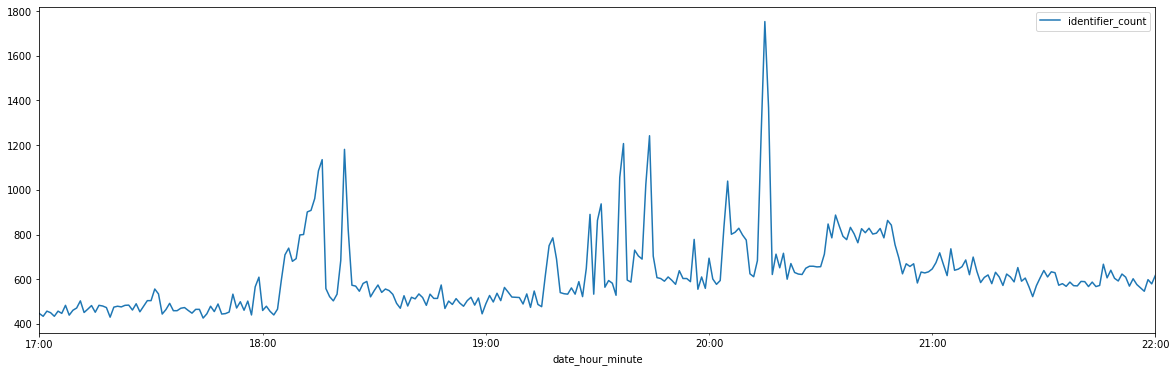

In [18]:
sessions_final_df_reporting_df.set_index("date_hour_minute", inplace=True)
# 1T represents 1 minute based sampling
sessions_final_df_reporting_df.resample("1T").apply(sum).plot(figsize=(20, 6))

In [19]:
# gathering tv advertisement start times
ads_start_list = list((tv_show_spot_df["ads_start_time"].dt.strftime("%Y-%m-%d %H:%M")))
ads_start_list

['2020-05-15 18:10',
 '2020-05-15 18:14',
 '2020-05-15 19:36',
 '2020-05-15 19:43',
 '2020-05-15 20:15']

* Our TV spots start at 18:10 and end at 20:15. Since the main task of this assignment is to find the TV probabilities (the correlations between the TV spots and identifier counts) we want to filter out unrelated time frames and focus on the TV spot hours.

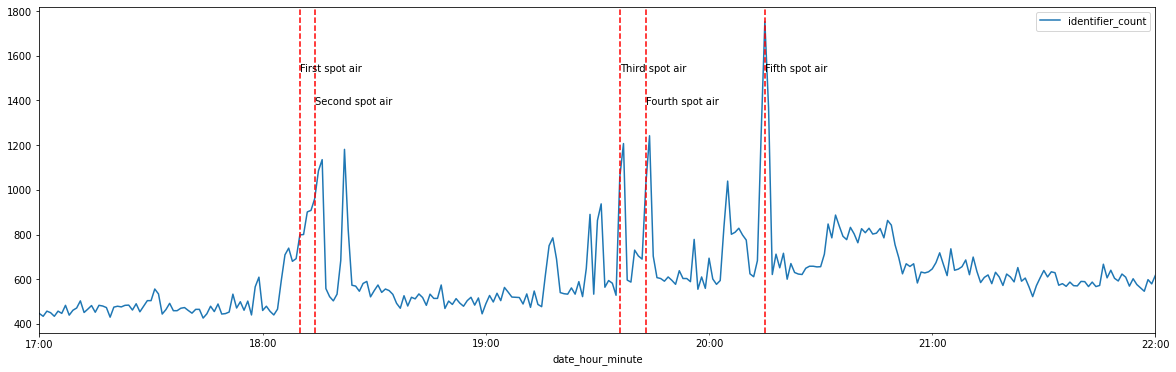

In [20]:
tv_spot_identifier_time_series_chart(
    sessions_final_df_reporting_df, "1T", ads_start_list
)

#### Findings 

* First Spot: "springsummer_branding", TV Show: "First Dates - Ein Tisch für zwei" and Second Spot: "springsummer_outfitfashionA", TV Show: "SOKO Kitzbühel" 
    * We see a significant but slow and small increase at visit counts after the spot aired.
    * In order to understand the real affect of the tv spot we need to compare the same time frame with no tv spot historical data; e.g. last 4 weeks without tv spot.
    * We didn't see any huge spike at these two spots. Maybe for this audience group & spot combination may have an affect in a larger amount of time.


* Third Spot: "springsummer_saleB", TV Show: "Alles was zählt", Forth Spot: "springsummer_saleA", TV Show: "Comeback oder weg?" and Fifth Spot: "springsummer_outfitfashionA", TV Show: "Jack Reacher"
    * We see huge spikes after these tv spots aired. 
    * After these spots aired and a certain period is over (couple minutes later), we detected huge drops in visits. This can also a good effect of the spot which caused high engagement.

## !!! Assumption !!!!

As we can see there are no spot overlappings during the day. In this regard spot analysis will not need any weighting affect.

### Calculating Background Noise

In a next step the background noise of visits from these channels is estimated:
* The TV relevant visits are aggregated on a per-minute basis
* Background noise value is calculated per minute:

Background noise for one minute x = median(visits in minute x-20; visits in minute x+20)

In [21]:
sessions_final_df_aggregated.head()

,date_hour_minute,identifier_count
0,2020-05-15 00:00:00,1249
1,2020-05-15 00:01:00,426
2,2020-05-15 00:02:00,322
3,2020-05-15 00:03:00,310
4,2020-05-15 00:04:00,278


## !!! Assumption !!!

"The algorithm assigned a tv_probability to sessions that occur within 5 minutes after a TV spot was aired."

Regarding the statement above what I understand and apply is that we are going to add 5 minutes to the spot air start time. Sample result is below;

* Spot Air Start Time: '2020-05-15 18:10'
* 5 Minute Period End Time: '2020-05-15 18:15'
* Date List in This Spot Period: '2020-05-15 18:10', '2020-05-15 18:11', '2020-05-15 18:12', '2020-05-15 18:13', '2020-05-15 18:14' and '2020-05-15 18:15'

## !!! Assumption !!!

"median(visits in minute x-20; visits in minute x+20)"

Regarding the statement above what I understand and apply is that we are going to add and substract 20 minutes to each 1 minute dates that has been calculated within the 5 minute duration. I don't include the upper and lower bounds during the calculations. 
Sample result is below;

* First 1 Minute Time: '2020-05-15 18:10'
* 20 Minute After the First 1 Minute Time: '2020-05-15 18:29'
* 20 Minute Before the First 1 Minute Time: '2020-05-15 17:51'

In [22]:
# gathering tv advertisement start times
ads_start_list = list((tv_show_spot_df["ads_start_time"].dt.strftime("%Y-%m-%d %H:%M")))
ads_start_list

['2020-05-15 18:10',
 '2020-05-15 18:14',
 '2020-05-15 19:36',
 '2020-05-15 19:43',
 '2020-05-15 20:15']

In [23]:
# creating empy Data Frame to fill with median values which are generated in the loop for each 1 minute session
median_df = pd.DataFrame(columns=["time", "time_new", "time_new_median"])

# in the nested for loop we are appending our median calculations to the original data frame (median_df)
for time in ads_start_list:  # looping through our spot list at our start list
    for i in range(0, 6):  # creating 5 minute interval block
        time_new = datetime.strptime(time, "%Y-%m-%d %H:%M") + timedelta(
            minutes=i
        )  # adding 1 minute at each turn

        # creating -20 and +20 minute block
        time_new_minus_20 = time_new - timedelta(
            minutes=20
        )  # substract 20 minute from the new date
        time_new_plus_20 = time_new + timedelta(
            minutes=20
        )  # add 20 minute to the new date

        # calculating median for each 1 minute within -20 and +20 minute period
        time_new_median = sessions_final_df_aggregated[
            (sessions_final_df_aggregated["date_hour_minute"] > time_new_minus_20)
            & (sessions_final_df_aggregated["date_hour_minute"] < time_new_plus_20)
        ]["identifier_count"].median()

        median_calculation_list = [
            time,
            time_new,
            time_new_median,
        ]  # creating a list object to store median calculations
        median_calculation_series = pd.Series(
            median_calculation_list, index=median_df.columns
        )  # converting list to a series object with original data frame column names to be appended to the original data frame
        median_df = median_df.append(
            median_calculation_series, ignore_index=True
        )  # appending to the original data frame

In [24]:
# time: spot air time
# time_new: spot air time adding minutes till 5 minute
# time_new_median: median calculations for each time_new
median_df.head(6)

,time,time_new,time_new_median
0,2020-05-15 18:10,2020-05-15 18:10:00,569.0
1,2020-05-15 18:10,2020-05-15 18:11:00,569.0
2,2020-05-15 18:10,2020-05-15 18:12:00,573.0
3,2020-05-15 18:10,2020-05-15 18:13:00,573.0
4,2020-05-15 18:10,2020-05-15 18:14:00,573.0
5,2020-05-15 18:10,2020-05-15 18:15:00,573.0


### Sanity Check to Median Calculation

I will manually parse the dates below from the sessions_final_df_aggregated table and manually calculate median value to compare with the for loop results.

* 20 Minute After the First 1 Minute Time: '2020-05-15 18:30'
* 20 Minute Before the First 1 Minute Time: '2020-05-15 17:50'

In [25]:
# manually filtering out and visualising results. 20th row is the median value of 41 sorted results.
sessions_final_df_aggregated[
    (sessions_final_df_aggregated["date_hour_minute"] >= "2020-05-15 17:50")
    & (sessions_final_df_aggregated["date_hour_minute"] <= "2020-05-15 18:30")
][["date_hour_minute", "identifier_count"]].sort_values(
    by=["identifier_count"]
).reset_index().iloc[
    20
]

index                              1078
date_hour_minute    2020-05-15 17:58:00
identifier_count                    566
Name: 20, dtype: object

### Peak Threshold Calculation

We aligned on a value p = 1.15.

In [26]:
median_df["peak_threshold"] = median_df["time_new_median"] * 1.15

In [27]:
median_df.head()

,time,time_new,time_new_median,peak_threshold
0,2020-05-15 18:10,2020-05-15 18:10:00,569.0,654.35
1,2020-05-15 18:10,2020-05-15 18:11:00,569.0,654.35
2,2020-05-15 18:10,2020-05-15 18:12:00,573.0,658.95
3,2020-05-15 18:10,2020-05-15 18:13:00,573.0,658.95
4,2020-05-15 18:10,2020-05-15 18:14:00,573.0,658.95


### TV probability calculation

For each minute during and up to 5 minutes after a TV spot is aired, it is checked if the TV relevant visits exceed the peak threshold:

* If the peak threshold is exceeded: each TV relevant session receives the TV probability (visits - background noise) / visits
* If the peak threshold is not exceeded: no TV probability is assigned

In [28]:
# merging median_df with sessions_final_df_aggregated data frame to compare thresholds with identifier counts
threshold_control = pd.merge(
    median_df,
    sessions_final_df_aggregated,
    how="inner",
    left_on="time_new",
    right_on="date_hour_minute",
)

In [29]:
threshold_control.head()

,time,time_new,time_new_median,peak_threshold,date_hour_minute,identifier_count
0,2020-05-15 18:10,2020-05-15 18:10:00,569.0,654.35,2020-05-15 18:10:00,798
1,2020-05-15 18:10,2020-05-15 18:11:00,569.0,654.35,2020-05-15 18:11:00,800
2,2020-05-15 18:10,2020-05-15 18:12:00,573.0,658.95,2020-05-15 18:12:00,901
3,2020-05-15 18:10,2020-05-15 18:13:00,573.0,658.95,2020-05-15 18:13:00,908
4,2020-05-15 18:10,2020-05-15 18:14:00,573.0,658.95,2020-05-15 18:14:00,961


In [69]:
# calculating tv_probability based on visits and background noise. I am assigning 0 to the probabilities if they can't exceed the thresholds for further analysis.
threshold_control["tv_prob"] = np.where(
    threshold_control["identifier_count"] > threshold_control["peak_threshold"],
    (threshold_control["identifier_count"] - threshold_control["time_new_median"])
    / threshold_control["identifier_count"],
    0,
)

### Findings

* By analysing the table above we can easily detect a pattern. At some spots the thresholds were only exceeded in the first two minutes. In this regard 3 to 5 minute affects couldn't exceed thresholds table above.

In [31]:
# events below couldn't pass the thresholds
threshold_control[threshold_control["tv_prob"] == 0]

,time,time_new,time_new_median,peak_threshold,date_hour_minute,identifier_count,tv_prob
9,2020-05-15 18:14,2020-05-15 18:17:00,573.0,658.95,2020-05-15 18:17:00,558,0.0
10,2020-05-15 18:14,2020-05-15 18:18:00,573.0,658.95,2020-05-15 18:18:00,522,0.0
11,2020-05-15 18:14,2020-05-15 18:19:00,569.0,654.35,2020-05-15 18:19:00,503,0.0
14,2020-05-15 19:36,2020-05-15 19:38:00,603.0,693.45,2020-05-15 19:38:00,596,0.0
15,2020-05-15 19:36,2020-05-15 19:39:00,603.0,693.45,2020-05-15 19:39:00,587,0.0
21,2020-05-15 19:43,2020-05-15 19:46:00,607.0,698.05,2020-05-15 19:46:00,607,0.0
22,2020-05-15 19:43,2020-05-15 19:47:00,607.0,698.05,2020-05-15 19:47:00,603,0.0
23,2020-05-15 19:43,2020-05-15 19:48:00,607.0,698.05,2020-05-15 19:48:00,591,0.0
26,2020-05-15 20:15,2020-05-15 20:17:00,683.0,785.45,2020-05-15 20:17:00,621,0.0
27,2020-05-15 20:15,2020-05-15 20:18:00,694.0,798.10,2020-05-15 20:18:00,712,0.0


In [32]:
# filtering out 0 tv probabilities
threshold_control = threshold_control[threshold_control["tv_prob"] > 0]

In [33]:
# adding a new column without second to join with threshold_control table
tv_show_spot_df["ads_start_time_date"] = tv_show_spot_df["ads_start_time"].dt.strftime(
    "%Y-%m-%d %H:%M"
)

In [34]:
tv_show_spot_df.head()

,tvp_id,block_start_time,tv_show,block_size,block_position,spot_id,spot_name,duration,ads_start_time,ads_end_time,ads_start_time_date
0,10001127236681063068_1553644644,2020-05-15 18:05:00,First Dates - Ein Tisch für zwei,420.0,345.0,4234.0,springsummer_branding,30 secs,2020-05-15 18:10:45,2020-05-15 18:11:15,2020-05-15 18:10
1,10001127236681063068_1553644645,2020-05-15 18:10:00,SOKO Kitzbühel,300.0,270.0,6232.0,springsummer_outfitfashionA,15 secs,2020-05-15 18:14:30,2020-05-15 18:14:45,2020-05-15 18:14
2,10001127236681063068_1553644646,2020-05-15 19:35:00,Alles was zählt,480.0,60.0,8331.0,springsummer_saleB,7 secs,2020-05-15 19:36:00,2020-05-15 19:36:07,2020-05-15 19:36
3,10001127236681063068_15536446461,2020-05-15 19:40:00,Comeback oder weg?,300.0,180.0,7224.0,springsummer_saleA,7 secs,2020-05-15 19:43:00,2020-05-15 19:43:07,2020-05-15 19:43
4,10001127236681063068_1553644647,2020-05-15 20:15:00,Jack Reacher,60.0,15.0,6232.0,springsummer_outfitfashionA,15 secs,2020-05-15 20:15:15,2020-05-15 20:15:30,2020-05-15 20:15


In [35]:
# joining all tables
final_calculation_df = pd.merge(
    threshold_control,
    tv_show_spot_df,
    how="left",
    left_on="time",
    right_on="ads_start_time_date",
)[
    [
        "tvp_id",
        "tv_show",
        "spot_id",
        "spot_name",
        "ads_start_time",
        "time_new",
        "time_new_median",
        "peak_threshold",
        "identifier_count",
        "tv_prob",
    ]
].rename(
    columns={
        "identifier_count": "visit_count",
        "time_new": "ads_start_time_5_min_duration",
        "time_new_median": "visit_median",
    }
)

In [36]:
# removing seconds from the duration column to be merged with the sessions table
final_calculation_df["ads_start_time_5_min_duration"] = final_calculation_df[
    "ads_start_time_5_min_duration"
].dt.strftime("%d.%m.%y %H:%M")

In [37]:
final_calculation_df.head()

,tvp_id,tv_show,spot_id,spot_name,ads_start_time,ads_start_time_5_min_duration,visit_median,peak_threshold,visit_count,tv_prob
0,10001127236681063068_1553644644,First Dates - Ein Tisch für zwei,4234.0,springsummer_branding,2020-05-15 18:10:45,15.05.20 18:10,569.0,654.35,798,0.286967
1,10001127236681063068_1553644644,First Dates - Ein Tisch für zwei,4234.0,springsummer_branding,2020-05-15 18:10:45,15.05.20 18:11,569.0,654.35,800,0.288750
2,10001127236681063068_1553644644,First Dates - Ein Tisch für zwei,4234.0,springsummer_branding,2020-05-15 18:10:45,15.05.20 18:12,573.0,658.95,901,0.364040
3,10001127236681063068_1553644644,First Dates - Ein Tisch für zwei,4234.0,springsummer_branding,2020-05-15 18:10:45,15.05.20 18:13,573.0,658.95,908,0.368943
4,10001127236681063068_1553644644,First Dates - Ein Tisch für zwei,4234.0,springsummer_branding,2020-05-15 18:10:45,15.05.20 18:14,573.0,658.95,961,0.403746


In [38]:
# merging sessions table with final_calculation_df to gather which visit had a valid tv probability calculation
home_assignment_final_df = pd.merge(
    sessions_final_df,
    final_calculation_df,
    how="inner",
    left_on="date_hour_minute",
    right_on="ads_start_time_5_min_duration",
)[["origin", "channel", "identifier", "date_hour_minute", "tvp_id", "tv_prob"]]

In [51]:
home_assignment_final_df["date_hour_minute"] = pd.to_datetime(
    home_assignment_final_df["date_hour_minute"]
)

In [46]:
home_assignment_final_df.head()

,origin,channel,identifier,date_hour_minute,tvp_id,tv_prob
0,app,Direct App,68308b2ca17ca3554546bbf7e8,15.05.20 18:10,10001127236681063068_1553644644,0.286967
1,app,Direct App,cb51890263cb49761253403353,15.05.20 18:10,10001127236681063068_1553644644,0.286967
2,app,Direct App,cca4b65d88d67b1acf79c4dc71,15.05.20 18:10,10001127236681063068_1553644644,0.286967
3,web,Direct,234371511550390009,15.05.20 18:10,10001127236681063068_1553644644,0.286967
4,web,Direct,5798477480565300009,15.05.20 18:10,10001127236681063068_1553644644,0.286967


## Comparing Results: Elif vs AboutYou :) 

* In this comparison I will focus on various parts;
    * What is the tv probability difference distribution between our findings?
    * What are the highest and lowest tv probability differences between our findings? 
    * What are Matching and Non-Matching identifier counts?

In [75]:
# merging your and my results in comparison_df to calculate the differences
comparison_df = pd.merge(
    tv_visits_match_df,
    home_assignment_final_df,
    how="left",
    on=["identifier", "tvp_id", "date_hour_minute"],
).drop_duplicates()

# Final Conclusion and Findings

* I have compared my findings to your tv_visits_match table and I have detected some differences;
    * "sessions that occur within 5 minutes after a TV spot was aired.": In my calculations I have added 5 minutes to spot air time and calculated a duration of 6 minutes. In your table you have calculated 7 minutes which means you have added 6 minutes to the duration. This will result a non matching last minute in our analysis. Based on the document I believe my way of calculation seems to be the correct one. But his cause your final data set has 243 more visits than mine.
    * "2 or more spots are aired at the same time": In the documentation you mentioned that spot overlap can only be existed as long as 2 or more spots were aired at the same time. But in your table you calculated overlap based on the duration period overlaps not the air time overlaps. For example; last 2 minutes of 5 minute duration of tvp_id "10001127236681063068_1553644644" overlaps with first two minutes of 5 minute duration of tvp_id "10001127236681063068_1553644645".

In [40]:
%who DataFrame

audience_df	 final_calculation_df	 home_assignment_final_df	 median_df	 sessions_final_df	 sessions_final_df_aggregated	 sessions_final_df_reporting_df	 threshold_control	 tv_planning_df	 
tv_show_spot_df	 tv_spots_df	 tv_visits_match_df	 
